In [ ]:
import numpy as np
import pandas as pd
import dask.dataframe as dk
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# file_path = "Processed_Data/Mapped_Dataset.csv"
# file_path="C:/Users/hoang/FileCSV_DACN_2025/Benign_ddos_dos_Mapped_Dataset.csv"
file_path = "/mnt/d/DoAnChuyenNganh_Train/data/remapping_dataset_2type.csv"

df = dk.read_csv(file_path)
# df.drop(columns=['Variance', 'Weight'])
print(df.dtypes)
print(df.head())

flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP               float64
IPv                float64
LLC                float64
Tot sum            float64
Min                float64
Max                float64
AVG                float64
S

: 

label
0    1098195
1    3999996
Name: count, dtype: int64


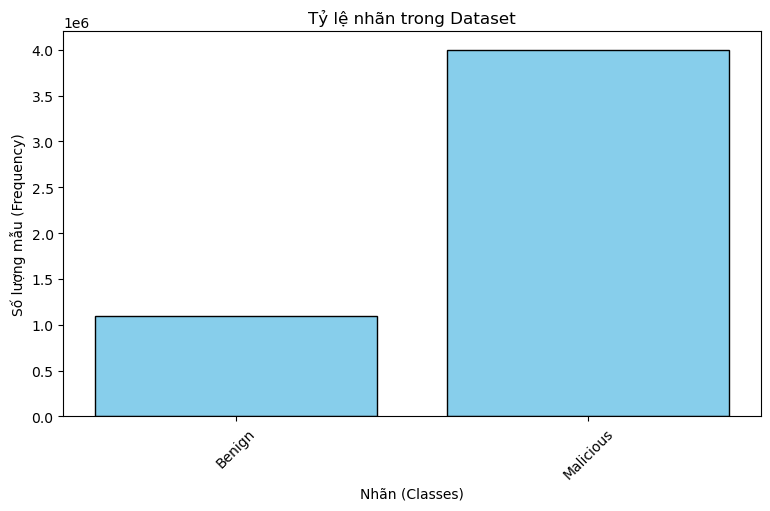

In [2]:
import matplotlib.pyplot as plt

# labels = ['BenignTraffic', 'DDoS-ICMP_Flood', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 
#                    'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood']
# Đếm số lượng mỗi nhãn
label_counts = df['label'].value_counts().compute()
print(label_counts)
labels = ["Benign", "Malicious"]
# Vẽ biểu đồ cột
plt.figure(figsize=(9, 5))
plt.bar(labels, label_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Nhãn (Classes)")
plt.ylabel("Số lượng mẫu (Frequency)")
plt.title("Tỷ lệ nhãn trong Dataset")
plt.xticks(range(len(labels)) ,labels, rotation =45)
plt.show()

In [2]:
#Global var 
batch_size = 512
ratio_test_all = 0.20

from dask_ml.model_selection import train_test_split 
# chia train test ratio 0.8:0.2 & random 
train_df, val_test_df = train_test_split(df, test_size=ratio_test_all, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.75, random_state=42)

# # load từng batch
def dask_to_tf_dataset(dask_df, batch_size): 
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()  
            if batch.empty:
                continue

            X = batch.drop(columns='label').values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)  # nhị phân: 0 hoặc 1

            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)

            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch

    output_signature = ( 
        tf.TensorSpec(shape=(None, 46), dtype=tf.float32), 
        tf.TensorSpec(shape=(None,), dtype=tf.int32),  # không phải one-hot nữa
    )
    
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

/home/hoangvn/miniconda3/miniconda3/envs/doan/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(
/home/hoangvn/miniconda3/miniconda3/envs/doan/lib/python3.9/site-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [3]:
train_gen = dask_to_tf_dataset(train_df, 512).repeat()
test_gen = dask_to_tf_dataset(test_df, 512)
val_gen = dask_to_tf_dataset(val_df, 512).repeat()

I0000 00:00:1746591191.055255  225830 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:02:00.0, compute capability: 7.5


In [ ]:
from datetime import datetime, timedelta
import sys, os
# shape
features, labels = next(iter(train_gen))
input_shape = (features.shape[1], 1)
# output_shape = labels.shape[1]

print(f"Input Shape: {input_shape}")

from tensorflow import keras
# Định nghĩa mô hình CNN
# VGG, ...
# Conv2D, tabular, ...
# HE, tính tương thích của HE với CNN
# Tính chất data in, out; Học tăng cường
start_time = datetime.now()

model = keras.Sequential([
    #layers.Input(shape=input_shape),
    #layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"),
    #layers.BatchNormalization(),
    #layers.Conv1D(filters=128, kernel_size=7, padding="same", activation="relu"),
    #layers.BatchNormalization(),
    #layers.MaxPooling1D(pool_size=2),
    #layers.Dropout(0.5),
    #layers.Flatten(),
    #layers.Dense(128, activation='relu'),
    layers.Input(shape=input_shape),
    layers.Conv1D(filters=64, kernel_size=3, padding="same", strides=1, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, padding="same", strides=1, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    # layers.Dense(64, activation='relu'),  
    # layers.Dropout(0.3),                  
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
# for batch in dataloader:
#     X_batch = batch[:, :-1]
#     y_batch = batch[:, -1]
#     y_onehot = to_categorical(y_batch, num_classes=10)
    
#     model.train_on_batch(X_batch, y_onehot, verbose=1)
from tensorflow.keras.callbacks import CSVLogger
os.makedirs("log_mono", exist_ok=True)
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
csv_logger = CSVLogger("log_mono/"+ datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".csv" , append=True)
model.fit(train_gen, epochs=50, validation_data=val_gen, validation_steps= 498 , steps_per_epoch=7968, verbose = 1, callbacks=[csv_logger])


end_time = datetime.now()
simulated_time = end_time - start_time
model_name = "model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras"
# Lưu mô hình
model.save(model_name)

print(f"Simulated time: {simulated_time}")

Input Shape: (46, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 46, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 46, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 46, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 46, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 23, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 736)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 736)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        47,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,305 (212.13 KB)

 Trainable params: 53,985 (210.88 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 128s 15ms/step - accuracy: 0.9901 - loss: 0.0569 - val_accuracy: 0.2095 - val_loss: 2.0676
Epoch 2/50
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 106s 13ms/step - accuracy: 0.9745 - loss: 0.0818 - val_accuracy: 0.9999 - val_loss: 0.2020
Epoch 3/50
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 117s 15ms/step - accuracy: 0.9931 - loss: 0.0190 - val_accuracy: 0.7907 - val_loss: 0.4235
Epoch 4/50
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 121s 15ms/step - accuracy: 0.9996 - loss: 0.0066 - val_accuracy: 0.8947 - val_loss: 0.5388
Epoch 5/50
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 114s 14ms/step - accuracy: 0.9996 - loss: 0.0047 - val_accuracy: 0.7905 - val_loss: 3.5498
Epoch 6/50
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 105s 13ms/step - accuracy: 0.9995 - loss: 0.0048 - val_accuracy: 0.7905 - val_loss: 1.0540
Epoch 7/50
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 104s 13ms/step - accuracy: 0.9991 - loss: 0.0054 - val_accuracy: 0.7905 - val_loss: 1.2813
Epoch 8/50
7968/7968 ━━━━━━━━━━━━━━━━━━━━ 100s 12ms/step - accuracy: 

2025-05-07 05:39:07.008621: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 106s 13ms/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 0.7905 - val_loss: 2.4727
Epoch 38/50
7279/7968 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9995 - loss: 0.0031

2025-05-07 05:40:45.043666: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 98s 12ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.7905 - val_loss: 1.2925
Epoch 39/50
7246/7968 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9995 - loss: 0.0031

2025-05-07 05:42:23.075200: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 99s 12ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.7905 - val_loss: 1.4336
Epoch 40/50
7269/7968 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9997 - loss: 0.0026

2025-05-07 05:44:06.291658: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 108s 14ms/step - accuracy: 0.9995 - loss: 0.0038 - val_accuracy: 0.7905 - val_loss: 2.4424
Epoch 41/50
7215/7968 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9995 - loss: 0.0026

2025-05-07 05:46:00.151841: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 120s 15ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.7905 - val_loss: 1.5426
Epoch 42/50
7215/7968 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9995 - loss: 0.0029

2025-05-07 05:47:52.209162: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 103s 13ms/step - accuracy: 0.9992 - loss: 0.0042 - val_accuracy: 0.7906 - val_loss: 2.4125
Epoch 43/50
7183/7968 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9995 - loss: 0.0023

2025-05-07 05:49:30.851833: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 106s 13ms/step - accuracy: 0.9993 - loss: 0.0034 - val_accuracy: 0.7905 - val_loss: 1.4742
Epoch 44/50
7195/7968 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9991 - loss: 0.0037

2025-05-07 05:51:19.212915: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 102s 13ms/step - accuracy: 0.9987 - loss: 0.0053 - val_accuracy: 0.8998 - val_loss: 0.7005
Epoch 45/50
7194/7968 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9990 - loss: 0.0041

2025-05-07 05:53:00.367986: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 101s 13ms/step - accuracy: 0.9985 - loss: 0.0059 - val_accuracy: 0.7905 - val_loss: 1.6424
Epoch 46/50
7149/7968 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9992 - loss: 0.0045

2025-05-07 05:54:43.178325: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 104s 13ms/step - accuracy: 0.9988 - loss: 0.0061 - val_accuracy: 0.7912 - val_loss: 1.3078
Epoch 47/50
7141/7968 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9990 - loss: 0.0038

2025-05-07 05:56:25.692000: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 103s 13ms/step - accuracy: 0.9986 - loss: 0.0055 - val_accuracy: 0.7907 - val_loss: 1.3160
Epoch 48/50
7148/7968 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9990 - loss: 0.0033

2025-05-07 05:58:09.316513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 103s 13ms/step - accuracy: 0.9986 - loss: 0.0049 - val_accuracy: 0.7905 - val_loss: 1.9236
Epoch 49/50
7127/7968 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9993 - loss: 0.0032

2025-05-07 05:59:51.538128: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 103s 13ms/step - accuracy: 0.9990 - loss: 0.0048 - val_accuracy: 0.7905 - val_loss: 1.3856
Epoch 50/50
7136/7968 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9996 - loss: 0.0025

2025-05-07 06:01:36.528834: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 96632 bytes after encountering the first element of size 96632 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


7968/7968 ━━━━━━━━━━━━━━━━━━━━ 107s 13ms/step - accuracy: 0.9994 - loss: 0.0037 - val_accuracy: 0.7905 - val_loss: 1.0039
Simulated time: 1:27:12.794386


In [6]:
from tensorflow.keras.models import load_model
#input_model = "saved_model/cnn_model_2-0_batch512_" + datetime.now().strftime("%Hh%Mp__%d-%m-%Y")+".keras"
model = load_model(model_name)

output = model.evaluate(test_gen, steps = 1493)
print(f'Loss: {output[0]} Acc: {output[1]}')

  91/1493 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.9998 - loss: 6.8175e-04

2025-05-06 20:37:44.848765: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 12 bytes spill stores, 12 bytes spill loads

2025-05-06 20:37:44.885293: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 132 bytes spill stores, 132 bytes spill loads

2025-05-06 20:37:45.025468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 216 bytes spill stores, 220 bytes spill loads



 127/1493 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.9999 - loss: 6.6348e-04

2025-05-06 20:37:46.755966: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 216 bytes spill stores, 220 bytes spill loads

2025-05-06 20:37:46.940015: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 12 bytes spill stores, 12 bytes spill loads

2025-05-06 20:37:46.998203: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 132 bytes spill stores, 132 bytes spill loads



 335/1493 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9999 - loss: 4.6254e-04

2025-05-06 20:37:50.599078: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 132 bytes spill stores, 132 bytes spill loads

2025-05-06 20:37:50.794586: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 12 bytes spill stores, 12 bytes spill loads

2025-05-06 20:37:50.842348: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 216 bytes spill stores, 220 bytes spill loads



 364/1493 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - accuracy: 0.9999 - loss: 4.4486e-04

2025-05-06 20:37:51.979200: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 12 bytes spill stores, 12 bytes spill loads

2025-05-06 20:37:52.129748: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 132 bytes spill stores, 132 bytes spill loads

2025-05-06 20:37:52.166199: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_101', 216 bytes spill stores, 220 bytes spill loads



1493/1493 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9999 - loss: 7.7026e-04
Loss: 0.0032587985042482615 Acc: 0.999374508857727


2025-05-06 20:37:59.729980: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-06 20:37:59.730037: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-05-06 20:37:59.730048: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 2616374497894916599
2025-05-06 20:37:59.730076: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 5022527948573190775
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function whe

Batch test:  1493


2025-05-06 20:41:03.081779: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 4 bytes spill stores, 4 bytes spill loads

2025-05-06 20:41:03.160263: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 12 bytes spill stores, 12 bytes spill loads

2025-05-06 20:42:57.562417: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Precision:  0.9992332464345959
Recall:  0.9999699744783066
F1-Score:  0.9996014747103188


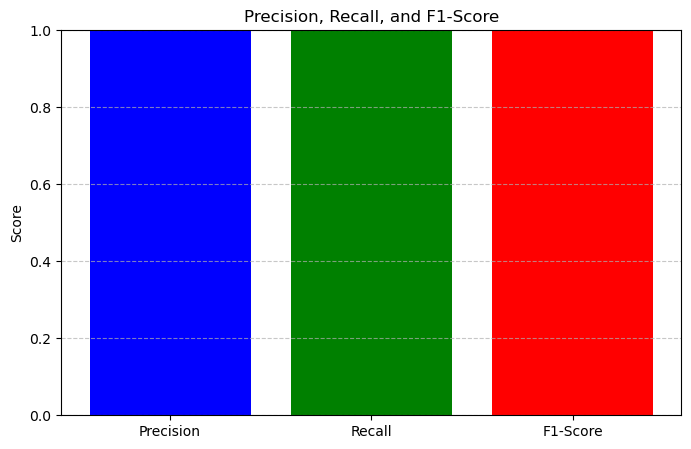

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

#input_model = "/home/hoangvn/Enhancing_PP_of_FL_for_IDS/saved_model/cnn_model_2-0_batch512_10h07p__13-04-2025.keras"
model = load_model(model_name)
#model = load_model("saved_model/cnn_model_2-0_batch512_20h37p__06-05-2025.keras")
# Tính số hàng thật sự trong test_df
num_samples_test = test_df.shape[0].compute()
# Tính số batch
num_batches_test = int(np.ceil(num_samples_test / batch_size))
print("Batch test: ", num_batches_test)

y_true_all = []
y_pred_all = []

for X_batch, y_batch in test_gen.take(num_batches_test):
    y_true_all.extend(y_batch.numpy().flatten())

    y_pred_prob = model.predict(X_batch, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_pred_all.extend(y_pred)

# Tính metric
precision = precision_score(y_true_all, y_pred_all, average='binary')
recall = recall_score(y_true_all, y_pred_all, average='binary')
f1 = f1_score(y_true_all, y_pred_all, average='binary')

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-Score: ", f1)

param_names = ['Precision', 'Recall', 'F1-Score']
array = [precision, recall, f1]

x = np.arange(len(param_names))
width = 0.2  # Độ rộng của mỗi cột
plt.figure(figsize=(8, 5))
plt.bar(param_names, array, color=['blue', 'green', 'red'])

# Cấu hình trục và nhãn
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.ylim(0, 1)  # Giá trị từ 0 đến 1
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị biểu đồ
plt.show()


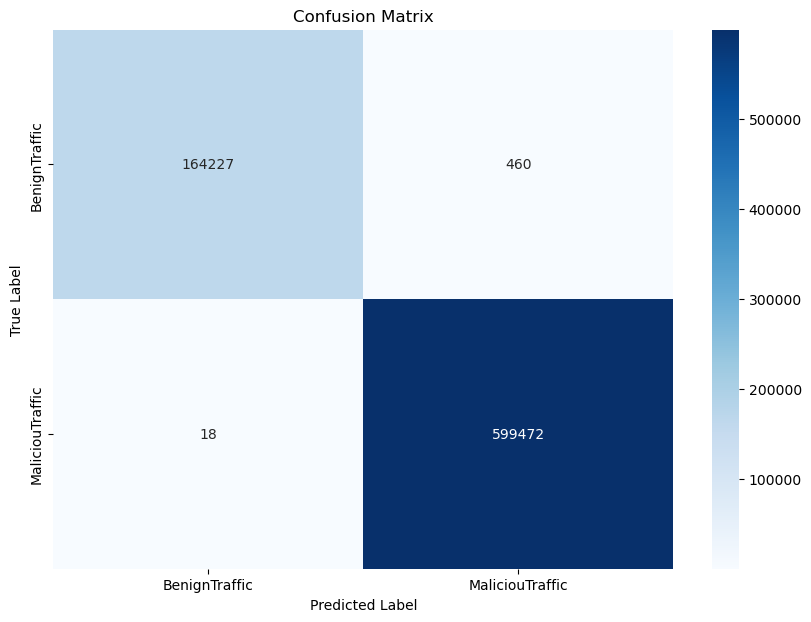

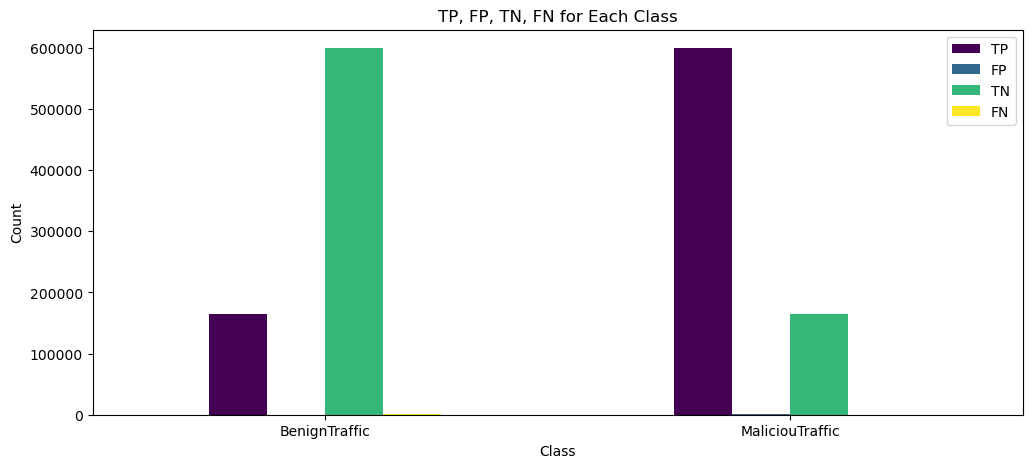

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true_all, y_pred_all)

attack_types =['BenignTraffic', 'MaliciouTraffic']
# Vẽ heatmap
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)

# Thêm nhãn
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Hiển thị
plt.show()


metrics = []
num_classes = len(attack_types)

# Duyệt từng lớp để tính TP, FP, TN, FN
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    metrics.append([attack_types[i], TP, FP, TN, FN])

# Chuyển thành DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
# Vẽ biểu đồ
df_metrics.set_index("Attack_Types").plot(kind="bar", figsize=(12, 5), colormap="viridis")

# Thêm nhãn
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("TP, FP, TN, FN for Each Class")
plt.xticks(rotation=0)
plt.legend(["TP", "FP", "TN", "FN"])

# Hiển thị
plt.show()

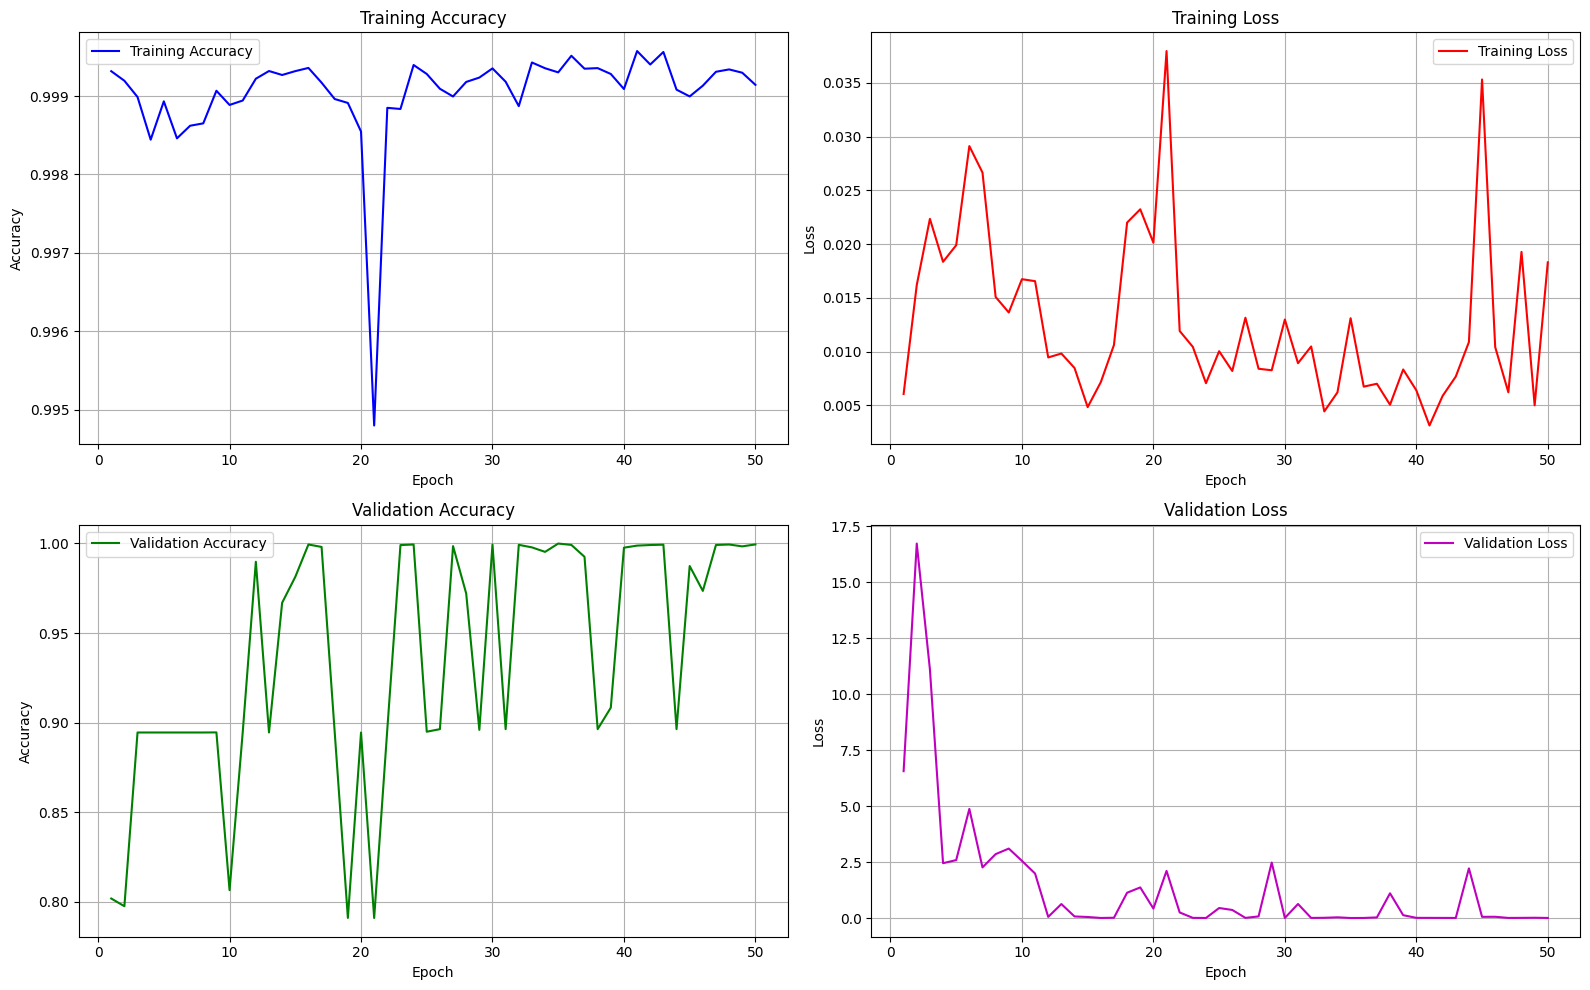

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc log từ file CSV
log_df = pd.read_csv('log_mono/19h56p__06-05-2025.csv')  # Đổi tên file nếu cần

epochs = range(1, len(log_df) + 1)

plt.figure(figsize=(16, 10))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Validation Loss
plt.subplot(2, 2, 4)
plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
